In [1]:
%matplotlib inline
from numpy import *
from matplotlib.pyplot import *

import numpy as np
import matplotlib.pyplot as plt
import sympy as sym
import scipy.sparse as sp
import scipy.linalg 
from numpy.linalg import inv

Consider the following one-dimensional PDE:
$$
-u_{xx}(x) = f(x)\quad\mathrm{ in }\ \Omega = (0, \pi)
$$
$$
u(x) = 0, \quad\mathrm{ on }\ \partial\Omega = \{0, \pi\}
$$

Given the following $4^{th}$ order finite difference approximation of the second order derivative:

$$u_{xx}(x_i) = \frac{-u_{i-2}+16u_{i-1}-30u_i+16u_{i+1}-u_{i+2}}{12h^2}$$

Implement a function that given the domain interval, the forcing function, the number of discretization points, the boundary conditions, returns the matrix $A$ and the the right hand side $b$.

In [2]:
def finDif(omega,f,n,bc):

    # defining mesh size and number of equispaced mesh points
    h = (omega[1]-omega[0])/n
    x = np.linspace(omega[0],omega[1],n+1)

    #creating a sparse matrix 
    data = [-np.ones(n-1),16*np.ones(n), -30*np.ones(n+1), 16*np.ones(n), -np.ones(n-1)]
    A = sp.diags(data, [-2, -1, 0, 1, 2], format = "lil")
    A /= -12*h**2

    #RHS 
    b = f(x)     

    # applying BC's for RHS funstion 
    b[0] = bc[0] 
    b[-1] = bc[1] 

    # applying BCs on first row in FD matrix 
    A[0,:] = 0; A[:,0] = 0 ; A[0,0] = 1 

    # applying BCs on last row in FD matrix 
    A[-1,:] = 0; A[:,-1] = 0 ; A[-1,-1] = 1  
    
    A = A.toarray()
    return A, b

Call the function using:

In [3]:
omega = [0,pi]
f = lambda x : sin(x)
n=100
x = np.linspace(omega[0],omega[1],n+1)
bc = [0,0]
A, b = finDif(omega, f, n, bc)

Implement two functions that compute the LU and the Cholesky factorization of the system matrix $A$

**LU factorization :**

*for i = 1,.........n*

*for j = i+1,.......n*

$$l_{ji}= \frac{u_{ji}}{u_{ii}}$$   

$$u_{j}= {u_{j}}-{l_{ji}u_{i}}$$






In [4]:
def LU(A):
    # implementing Gauss Elimination method 

    N = A.shape[0]                                        # number of rows 
    U = A.copy()                                          # initilization of matrix U : upper triangular matrix
    L = np.eye(N)                                         # initilization of matrix L : lower triangular matrix as identity matrix of dimension N x N
    
    for i in range(N):                                    # looping over rows
            
        multiplier = U[i+1:, i] / U[i, i]                 # implementing the operations showed in the above block 

        L[i+1:, i] = multiplier
        U[i+1:] -= multiplier[:, np.newaxis] * U[i]    

    return L, U

L, U = LU(A)
np.allclose(A, L@U)                                       # verifying 

True

**Cholesky factorization :**

$$
r_{11}= \sqrt{a_{11}}
$$

for *i = 2, 3, 4,...... n* : 
$$
r_{j i}=\frac{1}{r_{j j}}\left(a_{i j}-\sum_{k=1}^{j-1} r_{k i} r_{k j}\right), \quad j = 1, \ldots, i-1;  
$$

$$
r_{ii}= \sqrt{a_{i j}-\sum_{k=1}^{j-1} r_{ki}^{2}}
$$


In [5]:
def cholesky(A):
    N = len(A)                                            # number of rows 
    for k in range(N-1):
        A[k,k] = sqrt(A[k,k])                             # implementing the operations showed in the above block
        A[k+1:,k] = A[k+1:,k]/A[k,k]
        
        for j in range(k+1,N):
            A[j:,j] = A[j:,j] - A[j:,k]*A[j,k]
        
    A[-1,-1] = sqrt(A[-1,-1])
    L=tril(A)
    return L, L.transpose()

A1 = A.copy()
HT, H = cholesky(A1)

np.allclose(A, HT@H)                                     # verifying

True

Implement forward and backward substitution functions to exploit the developed factorization methods to solve the derived linear system of equations.

**Forward substitution :**

$$ Ly = b $$

$$y_{1}= \frac{b_{1}}{l_{11}}$$

$$
y_{i}=\frac{1}{l_{i i}}\left(b_{i}-\sum_{j=1}^{i-1} l_{ij} y_{j}\right)  
$$


In [6]:
# Forward substitution 
def L_solve(L,b):
    y = zeros_like(b)
    N = len(L)
        
    y[0] = b[0]/L[0,0]
    for i in range(1,N):
        y[i] = (b[i] - dot(L[i, 0:i], y[0:i]))/L[i,i]
        
    return y

**Backward substitution :**

$$ Ux =y$$

$$x_{n}= \frac{y_{n}}{u_{nn}}$$

*for i = n-1, n-2, ....., 2, 1*

$$
x_{i}=\frac{1}{u_{i i}}\left(y_{i}-\sum_{j=i+1}^{n} u_{ij} x_{j}\right)  
$$


In [7]:
# Backward substitution 
def U_solve(U,y):
    x = zeros_like(y)
    N = len(U)

    x[-1] = y[-1]/U[-1,-1]
    for i in reversed(range(N-1)):
        x[i] = (y[i] - dot(U[i, i+1:N], x[i+1:N]))/U[i,i]
        
    return x

Solve the derived linear system using the implemented functions and plot the computed solution:

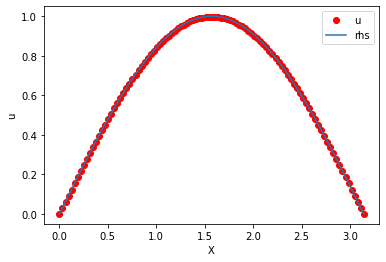

In [8]:
w = L_solve(L,b)
u = U_solve(U,w)

_ = plt.plot(x,u,'ro', label= "u")
_ = plt.plot(x,b, label= "rhs")
_ = plt.xlabel('X')
_ = plt.ylabel('u')
_ = plt.legend()

Considering the new domain $\Omega = (0,1)$ and the forcing term $f(x) = x(1-x)$ with B.C. $u(x) = 0$, on $\partial \Omega = {0,1}$ produce a plot and a table where you show the decay of the error w.r.t. the number of grid points.
(The analytical solution for the above problems is $u_{an} = \frac{x^4}{12} - \frac{x^3}{6} + \frac{x}{12}$)

Number of Grid points :  [  4.   8.  16.  32.  64. 128. 256. 512.]
Corresponding Errors  :  [1.37061404e-03 7.78937754e-04 3.99620238e-04 2.01033422e-04
 1.00666934e-04 5.03520769e-05 2.51783542e-05 1.25894660e-05]


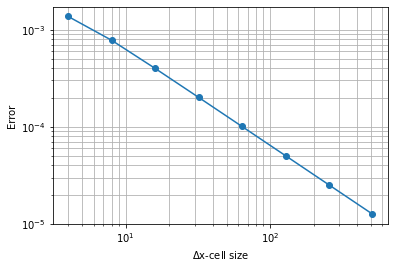

In [9]:
omega = [0,1]
f = lambda x : x*(1-x)                        # forcing term
bc = [0,0]

exp = 8
NN = zeros(exp)
e = zeros(exp)

for i in range(exp):
    N = 2**(i+2)                              # creating grid points of order 2
    NN[i]= N                                  # array of different grid points 
    A, b = finDif(omega, f, N, bc)
    L, U = LU(A)
    w = L_solve(L,b)
    u = U_solve(U,w)
    x = np.linspace(omega[0],omega[1],N+1)    

    u_an = (x**4)/12. - (x**3)/6. + x/12.     # computing analytical solution 

    e[i] =  max(abs(u - u_an))                # error  

print("Number of Grid points : ", NN)
print("Corresponding Errors  : ", e)
plt.loglog(NN, e, 'o-')
plt.grid(True, which="both", axis='both')
plt.xlabel('$\Delta$x-cell size')
plt.ylabel('Error')
plt.show()


<table>
<tr>
<td>Number of grid points </td>
<td>Error</td>
</tr>
<tr>
<td>4<td>1.37061404e-03</td>
<tr>
<td>8<td>7.78937754e-04</td>
<tr>
<td>16<td>3.99620238e-04</td>
<tr>
<td>32<td>2.01033422e-04</td>
<tr>
<td>64<td> 1.00666934e-04</td>
<tr>
<td>128<td>5.03520769e-05</td>
<tr>
<td>256<td>2.51783542e-05</td>
<tr>
<td>512<td>1.25894660e-05</td>
<tr>
<td>1024<td>6.29476942e-06</td>
<tr>
<td>2048<td>3.14739064e-06</td>
<tr>
<td>4096<td>1.57370123e-06</td>
<tr>
</table>

In [10]:
def solve(A, b):
    L, U, = LU(A)
    w = L_solve(L,b)
    u = U_solve(U,w)
    return u

Exploit the derived LU factorizations to compute the condition number of the system's matrix $A$ using the original problem formulation.

In [11]:
omega = [0,1]
f = lambda x : x*(1-x)
n=100
x = np.linspace(omega[0],omega[1],n+1)
bc = [0,0]
A, b = finDif(omega, f, n, bc)
print(f"Condition number obtained by using python inbuilt function = {linalg.cond(A):6f}")

Condition number obtained by using python inbuilt function = 53316.920822


In [12]:
def condNumb(A):
    A = A.copy()
    A_inv = solve(A, np.eye(A.shape[0]))                   # returns inverse of a matrix (solve function is shown in the above block)  
    condNu = dot(linalg.norm(A, 2), linalg.norm(A_inv, 2)) # K(A)=|A|.|A_inverse| (using L2 norm)  
    return condNu

cn = condNumb(A)
print(f"Condition number obtained by exploiting LU factorization = {cn:6f}")

Condition number obtained by exploiting LU factorization = 53316.920822


Implement a preconditioned Conjugant Gradient method to solve the original linear system of equations using an iterative method:

**Preconditioned conjugate gradient :**
   
   
   $$
   \alpha^k = \frac{{\bf p}^{k^{T}} {\bf r}^k}{(A{\bf p}^{k})^{T}{\bf p}^k}
   $$
   
      
   $$
   {\bf x}^{k+1} = {\bf x}^k + \alpha^k {\bf p}^k
   $$
   
   $$
   {\bf r}^{k+1} = {\bf r}^k - \alpha^kA {\bf p}^k
   $$

$$
P{\bf z}^{k+1} = {\bf r}^{k+1}
$$

   $$
   \beta^k = \frac{(A{\bf p}^{k})^{T}{\bf z}^{k+1}}{{\bf p}^{k^T}A  {\bf p}^k}
   $$
   
   $$
   {\bf p}^{k+1} = {\bf z}^{k+1} - \beta^k{\bf p}^k
   $$


In [13]:
def conjugate_gradient(A, b, P, nmax=len(A), eps=1e-10):
    N = len(A)
    rho_old = 1
    x =zeros_like(b)
    p_old = zeros_like(b)
    r = b - dot(A,x)                  # r0

    tol = eps + 1
    it = 0 
    while (it<nmax and tol>eps):      # stopping criteria
        it += 1 
        z = linalg.solve(P, r)
        rho = dot(r, z)
        if (it > 1):
            beta = rho/rho_old
            p = z + beta*p_old 
        else:
            p = z
        q = dot(A, p.T)               # implementing the above mentioned operations
        alpha = rho/(dot(p,q))
        x += alpha*p                  
        r -= alpha*q

        p_old = p
        rho_old = rho

        tol = linalg.norm(r, 2)
        
    print("Number of Iterations =",it,"\n"
          "Tolerance = ",tol)
    return x

In [14]:
sol_conjugate_gradient = conjugate_gradient(A, b, identity(len(A)))
u1 = solve(A, b) #by exploiting LU factorization
print("Error = ",linalg.norm(sol_conjugate_gradient - u1)/linalg.norm(u1))

Number of Iterations = 50 
Tolerance =  1.0244036483764923e-11
Error =  7.914659397897531e-15


Consider the following time dependent variation of the PDE starting from the orginal problem formulation:
$$
u'(t)-u_{xx} = \alpha(t)f(x)
$$

for $t\in [0,T]$, with $\alpha(t) = \cos(t)$ and $T = 6\pi$

Use the same finite difference scheme to derive the semi-discrete formulation and solve it using a forward Euler's method.

Plot the time dependent solution solution at $x = \pi/2$, $x=1$, 
$x=\pi$


$$u_{i}^{n+1} = u_{i}^{n} + \frac{Δt({-u_{i-2}+16u_{i-1}-30u_i+16u_{i+1}-u_{i+2}})}{12h^2} + Δt f_{i}^{n}$$

In [15]:
omega = [0, pi]
T = [0 , 6*pi]
Nx = 100
Nt = 10**3

# defining space scale and time scale 
x = linspace(omega[0], omega[1], Nx+1)
h = (omega[1] - omega[0])/(Nx+1)
t = linspace(T[0], T[1], Nt+1)
dt= (T[1]-T[0])/(Nt+1)

A, b = finDif(omega, f, Nx, bc)   # using the same finite difference scheme

IC = lambda x :0.5 * sin(x)       # initial condition
f = lambda t: cos(t) * sin(x)     # forcing term

u = zeros((len(x), len(t))) 

#Set initial condition u(x, 0) = I(X)
for i in range(1, Nx):
    u[i, 0]= IC(x[i])

for n in range(0, Nt):
    u[:, n+1] = u[:, n] + (dt/12*h**2)* A.dot(u[:,n]) + dt * f(t[n]) # implementing the scheme shown in the above block

In [16]:
y = where(isclose(x, 1, rtol=0.01))[0][0] #verifying the indices 
print(x[Nx], x[int(Nx/2)], x[y],y)

3.141592653589793 1.5707963267948968 1.0053096491487339 32


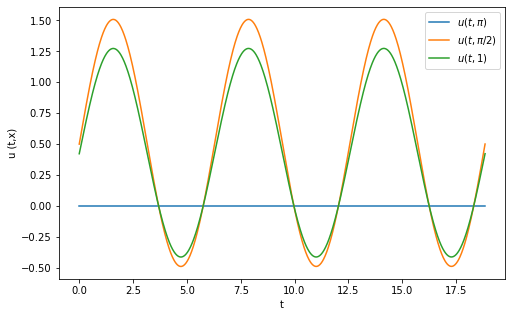

In [17]:
figure(figsize=[8,5])
_= plt.plot(t,u[Nx, :], label ="$u(t, \pi)$")
_= plt.plot(t,u[int(Nx/2),:], label ="$u(t, \pi/2)$")
_= plt.plot(t,u[y, :], label ="$u(t,1)$")
plt.xlabel('t')
plt.ylabel('u (t,x)')
plt.legend(loc='best') 
plt.show()

Given the original $Au = b$ system, implement an algorithm to compute the eigenvalues and eigenvectors of the matrix $A$. Exploit the computed LU factorization

In [18]:
omega = [0,pi]
f = lambda x : sin(x)
n=100
x = np.linspace(omega[0],omega[1],n+1)
bc = [0,0]
A, b = finDif(omega, f, n, bc)
A1 = A.copy()

**Dominant Eigen value**

**Power method :**


To find dominant eigenvalue $\lambda_{max}$

\begin{align}
\mathbf{y}_k & = \frac{\mathbf{x}^{k}}{\|\mathbf{x}^ {k}\|}\\
\mathbf{x}^k & = A\mathbf{y}^{k-1}\\
\lambda_{max}^k & = \mathbf{y}^T_k \mathbf{x}^k
\end{align}

In [19]:
def PM(L, U, n, tol=1e-5, nmax=10000):
    x0 = ones(n)
    y = x0/np.linalg.norm(x0,2)
    it = 0
    err = tol + 1.
    while it < nmax and err > tol:
        z = (L@U)@y                     # using lower and upper traingular matrices of matrix A in power method to obtain dominant eigen value
        l = dot(y.T,z)
        err = np.linalg.norm(z-l*y,2)
        y = z/np.linalg.norm(z,2)
        
        it += 1
    #print(f"error ={err}")
    #print(f"iterations ={it}"
    print(f"lambda_max = {l:6f}")
    return l,y                         # returns dominant eigen value

In [20]:
l_np, x_np = np.linalg.eig(A1)
print(f"np_lambda_max = {np.max(l_np):6f}")


La, Ua = LU(A1)                        # LU factorization
l, x = PM(La, Ua, La.shape[0])   

np_lambda_max = 5402.133526
lambda_max = 5402.133526



**solve function**
```
def solve(A, b):
    L, U, = LU(A)     # LU factorization 
    w = L_solve(L,b)  # forward substituion
    u = U_solve(U,w)  # backward substituion 
    return u
```


**Smallest Eigen Value**



**Inverse power method** 
To find dominant eigenvalue $\lambda_{min}$

\begin{align}
\mathbf{y}_k & = \frac{\mathbf{x}^{k}}{\|\mathbf{x}^ {k}\|}\\
\mathbf{x}^k & = A^{-1}\mathbf{y}^{k-1}\\
\lambda_{min}^k & = \frac{1}{\mathbf{y}^T_k \mathbf{x}^k}
\end{align}


In [21]:
def IPM(A,tol=1e-5,nmax=500):
      x0 = ones(A.shape[0])
      y = x0/np.linalg.norm(x0, 2)

      err = tol + 1.
      it = 0

      while it < nmax and err > tol:
          A_inv = solve(A, np.eye(A.shape[0]))  # returns matrix inverse (solve function shown above)
          z = dot(A_inv, y)
          l = dot(y.T,z)

          err = np.linalg.norm(z-l*y,2)
          y = z/np.linalg.norm(z,2)
          
          it += 1
      #print("error =", err, "iterations =", it)
      print(f"lambda_min = {1/l:6f}")           # returns smallest eigen value
      return l,y

In [22]:
l, q = IPM(A1)
l_np, x_np = np.linalg.eig(A1)                  # inbuilt function 
print("np_lambda_min  =",np.min(l_np))

lambda_min = 1.002007
np_lambda_min  = 1.0


Compute the inverse of the matrix A exploiting the derived LU factorization

In [23]:
I = np.eye(A.shape[0])    # RHS : Identity matrix
L, U = LU(A)              # LU factorization 
w = L_solve(L,I)          # calling forward substitution function  
A_inv = U_solve(U,w)      # calling backward substitution function  

np.allclose(A@A_inv, I)   # verifying the inverse matrix

True


Consider the following Cauchy problem
$$
\begin{cases}
y'= -ty^2 \quad 0\le t \le 2\\
y(0) = 1
\end{cases}
$$
Implement a Backward Euler's method in a suitable function and solve the resulting non-linear equation using a Newton's method.

**Newton's method :**

$$
y^{k+1} = y^k - \frac{f(y^k)}{f^{\prime}(y^k)}
$$

**After impelmenting backward euler's method in the cauchy's problem, we get** 


$$
F(y) = tΔt.(y^{n})^{2} + y^{n} - y^{n-1} 
$$

$$
F^\prime(y) = 2tΔt.y^{n} + 1 
$$

In [24]:
def Newtons(y0, t0, tf, N, eps= 1e-16, max_it=1000):
    errors = []
    iterations = []
                                                       
    t = np.linspace(t0, tf, N+1)                         # defining time scale
    dt = (tf-t0)/N

    y = zeros(N+1)
    y[0] = y0

    for n in range(1, N+1):
        a= dt*t[n-1]                                   
        b= 1
        c= -y[n-1]
        
        def F(y):
            return a*y**2 + b*y + c                     # returns F(y), as shown in the above block 
        
        def dF(y):                                        
            return 2*a*y + b                            # returns F_prime
        
        it = 0
        y_ = y[n-1]
        err = abs(F(y0))

        while (abs(F(y_)) > eps and it < max_it):       # stopping criteria 
            q = dF(y_)
            if abs(q) <1e-12:                                 
                raise RuntimeError("f_prime is close to zero")
                
            y_= y_ - F(y_)/dF(y_)                       # Newton's method  
            err = abs(F(y_))                            # error
            errors.append(err)
            it += 1

        y[n] = y_
        iterations.append(it)

    print('y =', y[N])
    print("error =", err, "iterations =", it)
    return y, t, errors

y = 0.33844739250913874
error = 5.551115123125783e-17 iterations = 3
Wall time: 16 ms


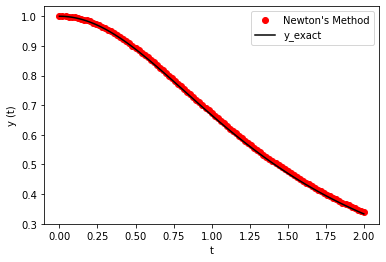

In [25]:
%time y, t, errors = Newtons(1, 0, 2, 100)
y_exact = 2/(t**2 + 2)                                 # exact solution

plt.plot(t,y,'ro',  label = "Newton's Method")
plt.plot(t,y_exact, 'k', label = 'y_exact')
plt.xlabel('t')
plt.ylabel('y (t)')
plt.legend() 
plt.show()